In [13]:
# Импорт необходимых библиотек
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import pickle
import pandas as pd
from tensorflow.keras.applications import Xception, VGG16, ResNet50
from tensorflow.keras.layers import (
                                    Activation,
                                    Conv2D,
                                    MaxPooling2D,
                                    BatchNormalization,
                                    ReLU,
                                    UpSampling2D,
                                    concatenate,
                                    Concatenate,
                                    Input,
                                    Add,
                                    ZeroPadding2D,
                                    Conv2DTranspose,
                                    RandomFlip,
                                    RandomRotation,
                                    RandomZoom,
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import time

In [14]:
# Гиперпараметры
EPOCHS = 25
BATCH_SIZE = 16
IMAGE_SIZE = 224

In [15]:
# Настройка датасета

## Путь к папкам с изображениями и масками
image_dir = '/kaggle/input/splitted-spheroids/images'
mask_dir = '/kaggle/input/splitted-spheroids/masks'

## Функция получения пути к маске
def convert_to_mask_path(image_path):
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_dir = os.path.dirname(image_path).replace('images', 'masks')
    return os.path.join(mask_dir, base_name + '_mask.png')

## Пути к изображениям и маскам
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
mask_paths = [convert_to_mask_path(image_path) for image_path in image_paths]

def load_image(image_path, mask_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0  # нормализация пикселей

    mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
    mask = img_to_array(mask) / 255.0  # нормализация пикселей (для бинарной маски)
    mask = np.round(mask)  # округление до 0 или 1
    
    return image, mask

def load_data(image_paths, mask_paths, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img, mask = load_image(img_path, mask_path, target_size)
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

## Загрузка всех данных
images, masks = load_data(image_paths, mask_paths)

## Разделение на тренировочный и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

Training set size: (384, 224, 224, 3)
Validation set size: (96, 224, 224, 3)


In [16]:
# Модель U-Net
def unet_model(input_size=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    inputs = Input(input_size)
    
    # Слои аугментации
    x = RandomFlip("horizontal_and_vertical")(inputs)
    x = RandomRotation(0.1)(x)
    x = RandomZoom(0.1)(x)
    
    # Base model VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    # Encoder
    conv1 = base_model.get_layer('block1_conv2').output
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = base_model.get_layer('block2_conv2').output
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = base_model.get_layer('block3_conv3').output
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = base_model.get_layer('block4_conv3').output
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = base_model.get_layer('block5_conv3').output

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [17]:
# Инициализация модели
model = unet_model()

In [18]:
# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Определяем ModelCheckpoint
checkpoint_path = "unet_checkpoint.weights.h5"
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=True,
                             mode='max')
# Обучение модели
start_time = time.time()
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[checkpoint],
    batch_size=BATCH_SIZE,
    verbose=0
)
end_time = time.time()
iteration_time = end_time - start_time
print(f"Время выполнения обучения: {iteration_time:.4f} секунд")


Epoch 1: val_accuracy improved from -inf to 0.84389, saving model to unet_checkpoint.weights.h5

Epoch 2: val_accuracy improved from 0.84389 to 0.96423, saving model to unet_checkpoint.weights.h5

Epoch 3: val_accuracy improved from 0.96423 to 0.97639, saving model to unet_checkpoint.weights.h5

Epoch 4: val_accuracy improved from 0.97639 to 0.97898, saving model to unet_checkpoint.weights.h5

Epoch 5: val_accuracy improved from 0.97898 to 0.98184, saving model to unet_checkpoint.weights.h5

Epoch 6: val_accuracy improved from 0.98184 to 0.98302, saving model to unet_checkpoint.weights.h5

Epoch 7: val_accuracy did not improve from 0.98302

Epoch 8: val_accuracy did not improve from 0.98302

Epoch 9: val_accuracy improved from 0.98302 to 0.98412, saving model to unet_checkpoint.weights.h5

Epoch 10: val_accuracy did not improve from 0.98412

Epoch 11: val_accuracy improved from 0.98412 to 0.98451, saving model to unet_checkpoint.weights.h5

Epoch 12: val_accuracy did not improve from 

In [29]:
# Сохранение модели
model.load_weights(checkpoint_path)
model.save_weights("unet_weights.h5")

# Сохраняем историю обучения
with open(f'history_unet.pickle', 'wb') as file:
    pickle.dump(history.history, file)

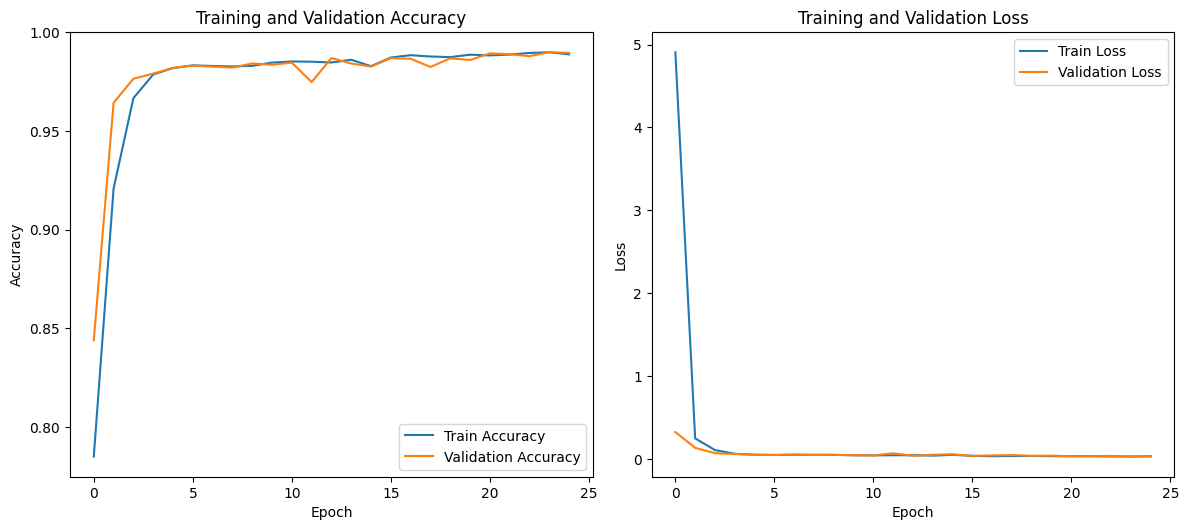

In [30]:
# Построение графиков ошибки и точности
plt.figure(figsize=(12, 10))

# График точности
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# График ошибки (Loss)
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# Генерация предсказаний на валидационном наборе
y_pred_probs = model.predict(X_val, batch_size=8)

def calculate_dice_coefficient(y_true, y_pred):
    smooth = 1e-7  # сглаживающий коэффициент для избежания деления на ноль
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def calculate_iou(y_true, y_pred):
    smooth = 1e-7  # сглаживающий коэффициент для избежания деления на ноль
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Функции для вычисления средних значений метрик для заданного порога
def calculate_mean_dice(y_true, y_pred_probs, threshold):
    y_pred = (y_pred_probs > threshold).astype(np.uint8)
    dice_scores = [calculate_dice_coefficient(y_true[i], y_pred[i]) for i in range(len(y_true))]
    return np.mean(dice_scores)

def calculate_mean_iou(y_true, y_pred_probs, threshold):
    y_pred = (y_pred_probs > threshold).astype(np.uint8)
    iou_scores = [calculate_iou(y_true[i], y_pred[i]) for i in range(len(y_true))]
    return np.mean(iou_scores)

def calculate_mean_pixel_accuracy(y_true, y_pred_probs, threshold):
    y_pred = (y_pred_probs > threshold).astype(np.uint8)
    pixel_accuracies = [calculate_pixel_accuracy(y_true[i], y_pred[i]) for i in range(len(y_true))]
    return np.mean(pixel_accuracies)

# Значения метрик
dice_score = calculate_mean_dice(y_val, y_pred_probs, 0.5)
iou_score = calculate_mean_iou(y_val, y_pred_probs, 0.5)
pixel_accuracy = calculate_mean_pixel_accuracy(y_val, y_pred_probs, 0.5)

print('Dice Coefficient at 0.5:', dice_score)
print("")
print('IoU at 0.5:', iou_score)
print("")
print('Pixel Accuracy at 0.5:', pixel_accuracy)
print("")

12/12 [==============================] - 1s 128ms/step
Dice Coefficient at 0.5: 0.9492329121571362

IoU at 0.5: 0.9172729728356565

Pixel Accuracy at 0.5: 0.9897967487776361



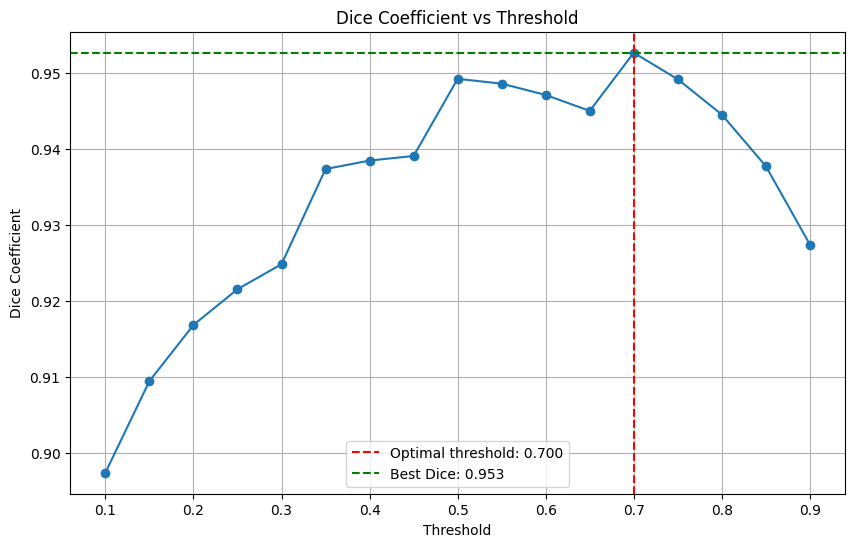

Оптимальный порог: 0.700
Лучший Dice Coefficient: 0.953

Метрики с оптимальным порогом:
Dice Coefficient: 0.953
IoU: 0.917
Pixel Accuracy: 0.989


In [37]:
# После получения y_pred_probs добавляем следующий код:

def find_optimal_threshold(y_true, y_pred_probs, metric_function, thresholds=None):
    """
    Находит оптимальный порог, максимизирующий выбранную метрику.
    
    Args:
        y_true: истинные маски
        y_pred_probs: предсказанные вероятности
        metric_function: функция метрики (например, dice_coefficient)
        thresholds: список порогов для проверки
    
    Returns:
        optimal_threshold: оптимальный порог
        best_score: лучшее значение метрики
        all_scores: словарь {порог: значение метрики}
    """
    if thresholds is None:
        thresholds = np.linspace(0.1, 0.9, 17)  # [0.1, 0.15, 0.2, ..., 0.9]
    
    scores = {}
    for threshold in thresholds:
        y_pred = (y_pred_probs > threshold).astype(np.uint8)
        score = np.mean([metric_function(y_true[i], y_pred[i]) for i in range(len(y_true))])
        scores[threshold] = score
    
    optimal_threshold = max(scores.items(), key=lambda x: x[1])[0]
    best_score = scores[optimal_threshold]
    
    return optimal_threshold, best_score, scores

# Поиск оптимального порога для Dice Coefficient
optimal_threshold, best_dice, all_dice_scores = find_optimal_threshold(y_val, y_pred_probs, dice_coefficient)

# Визуализация результатов
plt.figure(figsize=(10, 6))
thresholds = list(all_dice_scores.keys())
scores = list(all_dice_scores.values())

plt.plot(thresholds, scores, '-o')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal threshold: {optimal_threshold:.3f}')
plt.axhline(y=best_dice, color='g', linestyle='--', label=f'Best Dice: {best_dice:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

print(f"Оптимальный порог: {optimal_threshold:.3f}")
print(f"Лучший Dice Coefficient: {best_dice:.3f}")

# Пересчитываем все метрики с оптимальным порогом
dice_score = calculate_mean_dice(y_val, y_pred_probs, optimal_threshold)
iou_score = calculate_mean_iou(y_val, y_pred_probs, optimal_threshold)
pixel_accuracy = calculate_mean_pixel_accuracy(y_val, y_pred_probs, optimal_threshold)

print('\nМетрики с оптимальным порогом:')
print(f'Dice Coefficient: {dice_score:.3f}')
print(f'IoU: {iou_score:.3f}')
print(f'Pixel Accuracy: {pixel_accuracy:.3f}')

Generating predictions
6/6 [==============================] - 1s 185ms/step


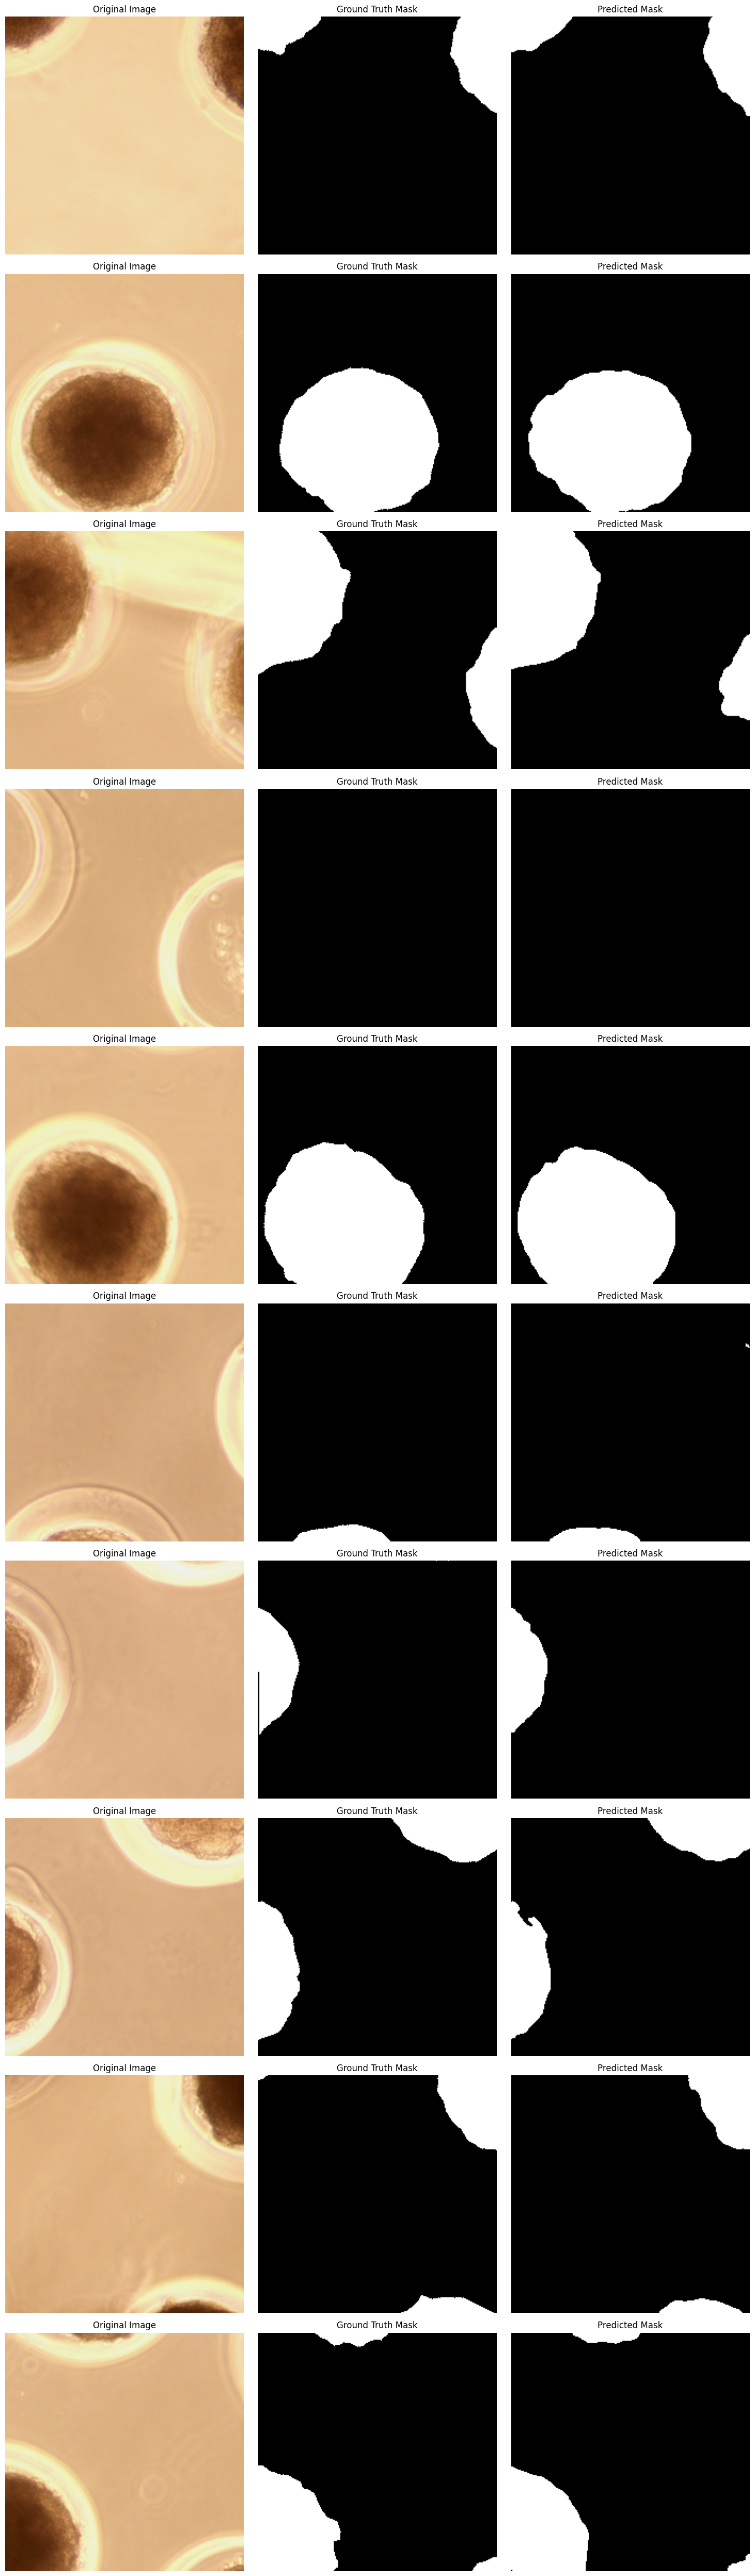

In [38]:
# Функция для отображения результатов
def display_examples(X_val, y_val, y_pred, num_examples=10, seed=12):
    random.seed(seed)  # Установка seed для воспроизводимости
    plt.figure(figsize=(15, num_examples * 5))
    
    for i in range(num_examples):
        idx = random.randint(0, len(X_val) - 1)  # Индекс выбирается одинаково при каждом запуске
        
        # Оригинальное изображение
        plt.subplot(num_examples, 3, 3 * i + 1)
        plt.imshow(X_val[idx])
        plt.title('Original Image')
        plt.axis('off')
        
        # Реальная маска
        plt.subplot(num_examples, 3, 3 * i + 2)
        plt.imshow(y_val[idx].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Предсказанная маска
        plt.subplot(num_examples, 3, 3 * i + 3)
        plt.imshow(y_pred[idx].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    
print("Generating predictions")
y_pred = model.predict(X_val, batch_size=BATCH_SIZE)
y_pred = (y_pred > optimal_threshold).astype(np.uint8)
display_examples(X_val, y_val, y_pred)

Обработка изображения: ARPE_4x_16.png
1/1 [==============================] - 0s 18ms/step


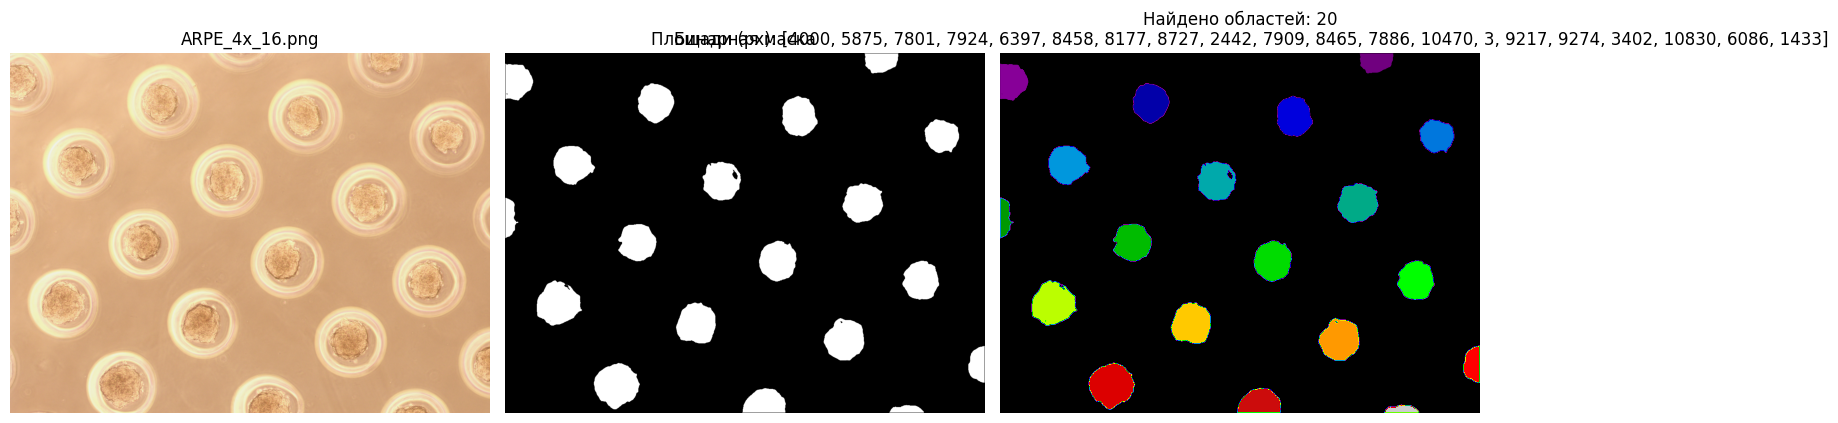

Обработка изображения: ARPE_4x_21.png
1/1 [==============================] - 0s 18ms/step


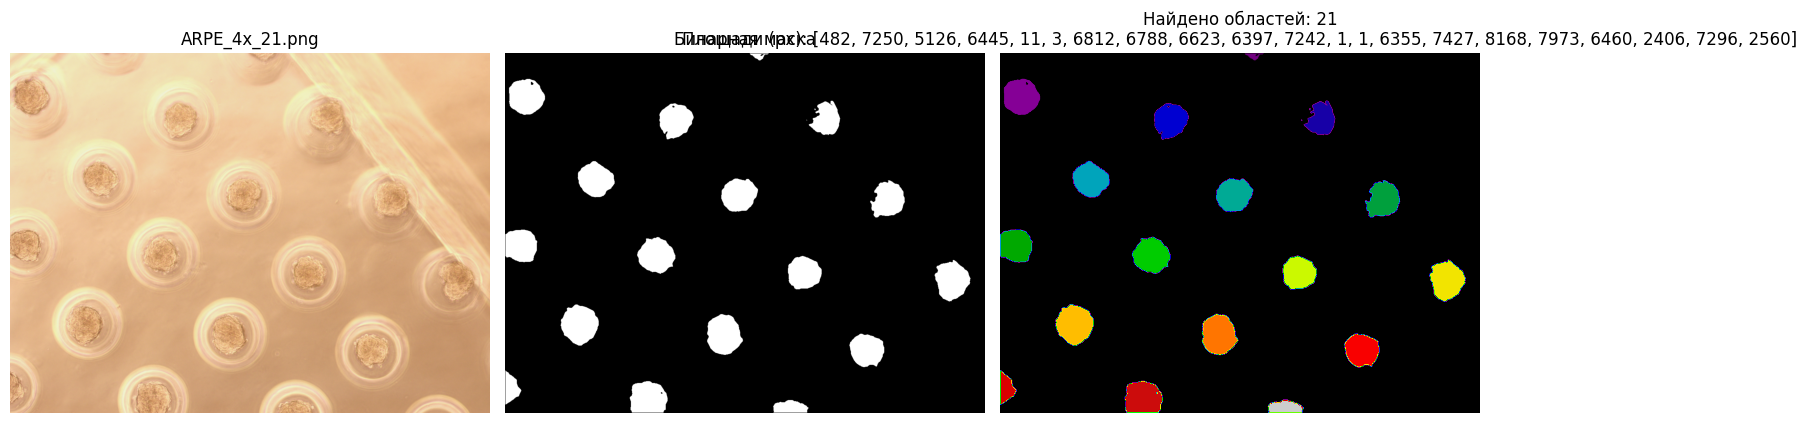

Обработка изображения: ARPE_4x_31.png
1/1 [==============================] - 0s 18ms/step


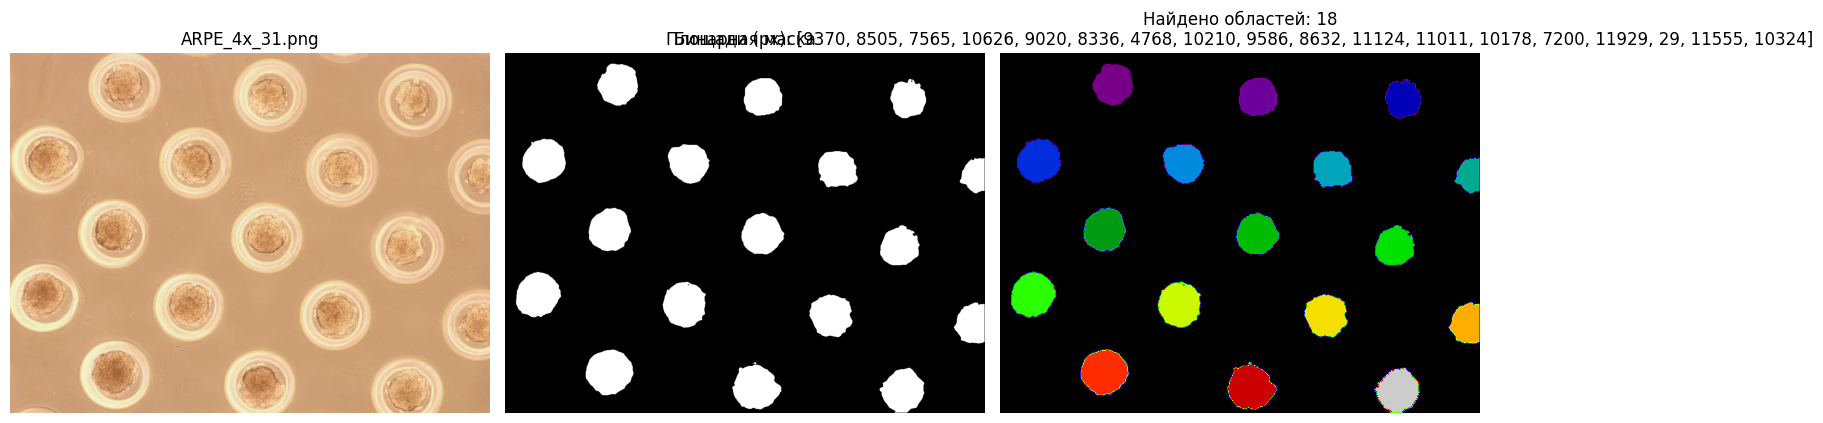

Обработка изображения: HepG2_4x_26.png
1/1 [==============================] - 0s 20ms/step


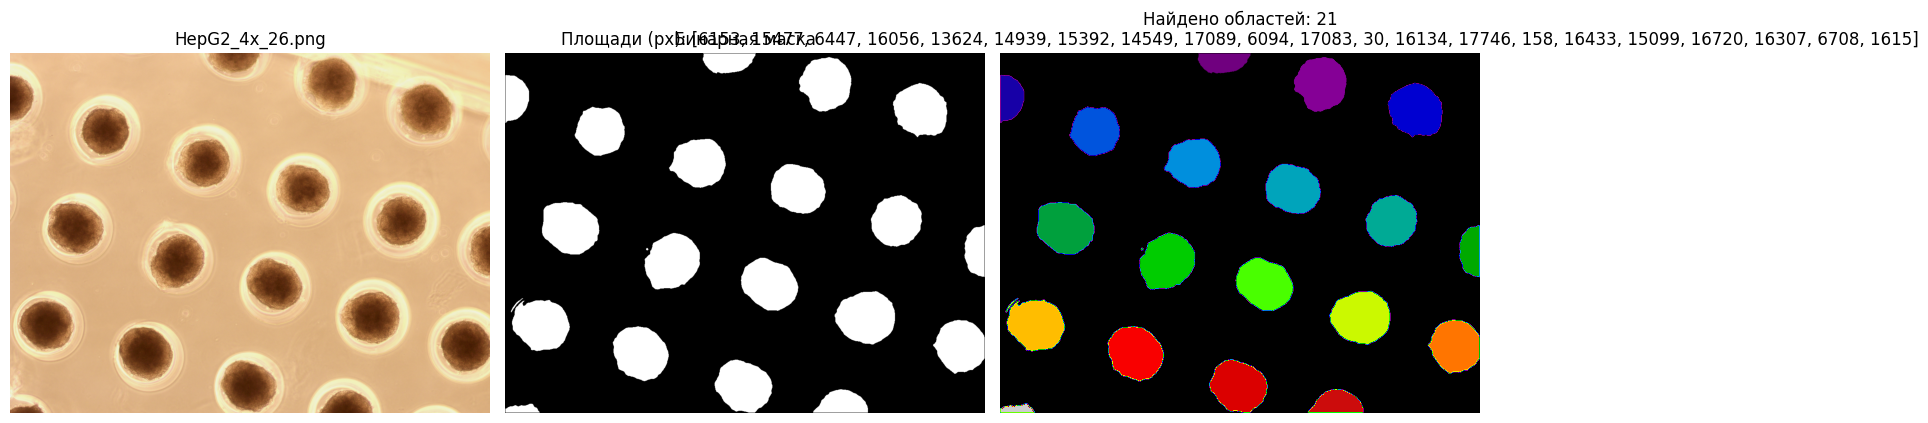

Обработка изображения: ARPE_4x_2.png
1/1 [==============================] - 0s 18ms/step


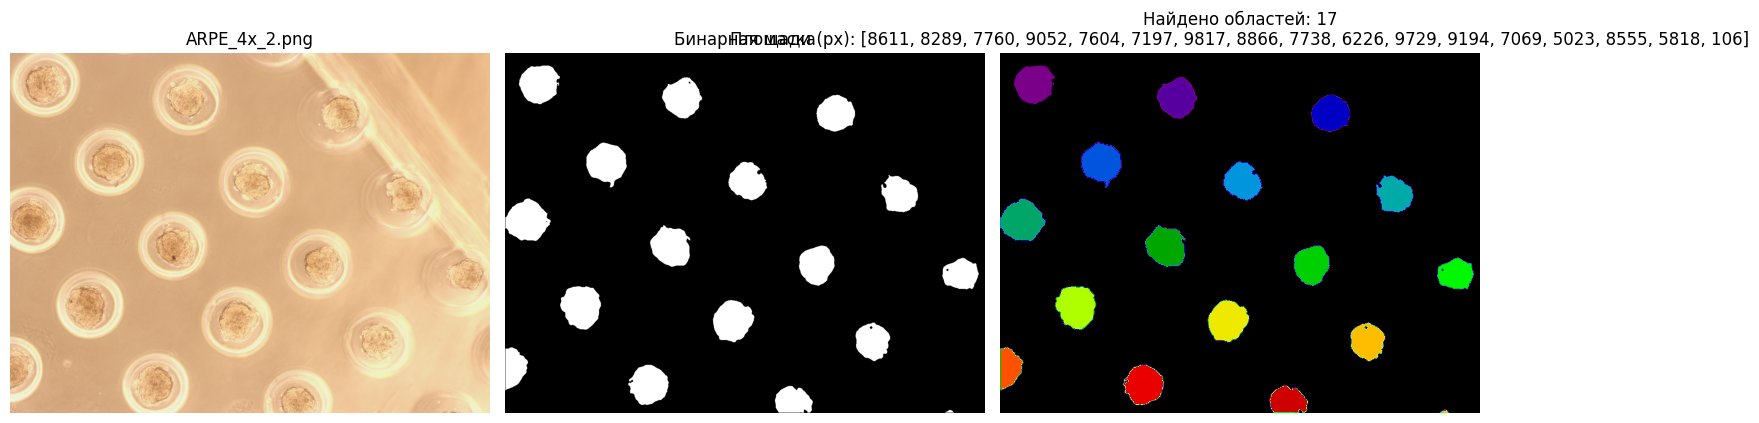

Отображено максимальное количество изображений: 5

Результаты измерений площадей:
          filename  num_regions  \
0   ARPE_4x_16.png           20   
1   ARPE_4x_21.png           21   
2   ARPE_4x_31.png           18   
3  HepG2_4x_26.png           21   
4    ARPE_4x_2.png           17   

                                        areas_pixels  total_area  
0  [4000, 5875, 7801, 7924, 6397, 8458, 8177, 872...      134776  
1  [482, 7250, 5126, 6445, 11, 3, 6812, 6788, 662...      101826  
2  [9370, 8505, 7565, 10626, 9020, 8336, 4768, 10...      159968  
3  [6153, 15477, 6447, 16056, 13624, 14939, 15392...      249853  
4  [8611, 8289, 7760, 9052, 7604, 7197, 9817, 886...      126654  

Результаты сохранены в файл 'spheroid_areas.csv'


In [39]:
from scipy import ndimage
from skimage import measure

def split_into_patches(image, patch_size=224, overlap=32):
    """
    Разбивает изображение на патчи с учетом границ изображения
    """
    patches = []
    h, w, _ = image.shape
    
    # Вычисляем количество шагов по каждой оси
    h_steps = max(1, int(np.ceil((h - patch_size) / (patch_size - overlap))) + 1)
    w_steps = max(1, int(np.ceil((w - patch_size) / (patch_size - overlap))) + 1)
    
    for i in range(h_steps):
        for j in range(w_steps):
            # Вычисляем координаты для текущего патча
            y_start = min(i * (patch_size - overlap), h - patch_size)
            x_start = min(j * (patch_size - overlap), w - patch_size)
            
            patch = image[y_start:y_start+patch_size, x_start:x_start+patch_size]
            patches.append((patch, y_start, x_start))
    
    return patches

def reconstruct_image(patches, image_shape, patch_size=224, overlap=32):
    """
    Восстанавливает изображение из патчей с корректной обработкой границ
    """
    h, w = image_shape[:2]
    reconstructed = np.zeros(image_shape)
    weights = np.zeros(image_shape[:2] + (1,))
    
    # Создаем весовую матрицу для плавного перехода
    weight_kernel = np.ones((patch_size, patch_size, 1))
    if overlap > 0:
        for i in range(overlap):
            weight_kernel[i, :, 0] *= (i / overlap)
            weight_kernel[-i-1, :, 0] *= (i / overlap)
            weight_kernel[:, i, 0] *= (i / overlap)
            weight_kernel[:, -i-1, 0] *= (i / overlap)
    
    for patch, y_start, x_start in patches:
        y_end = min(y_start + patch_size, h)
        x_end = min(x_start + patch_size, w)
        patch_h = y_end - y_start
        patch_w = x_end - x_start
        
        current_weight = weight_kernel[:patch_h, :patch_w]
        reconstructed[y_start:y_end, x_start:x_end] += patch[:patch_h, :patch_w] * current_weight
        weights[y_start:y_end, x_start:x_end] += current_weight
    
    # Избегаем деления на ноль
    mask = weights > 0
    reconstructed[mask] /= weights[mask]
    
    return reconstructed

def process_image(image_path, model, patch_size=224, overlap=32, threshold=0.5):
    """
    Обрабатывает одно изображение: разбивает на патчи, выполняет предсказание, объединяет маски.
    
    :param image_path: Путь к входному изображению.
    :param model: Обученная модель для сегментации.
    :param patch_size: Размер патча (по умолчанию 224).
    :param overlap: Перекрытие между патчами (по умолчанию 32).
    :param threshold: Порог для бинаризации маски (по умолчанию 0.5).
    :return: Оригинальное изображение и бинарная маска сегментации.
    """
    # Загрузка изображения
    image = load_img(image_path)
    image = img_to_array(image) / 255.0
    
    # Разбиение на патчи
    patches = split_into_patches(image, patch_size, overlap)
    
    # Предсказание для каждого патча
    predicted_patches = []
    for patch, i, j in patches:
        patch_input = np.expand_dims(patch, axis=0)  # Добавление батч-измерения
        pred = model.predict(patch_input)[0]  # Предсказание
        predicted_patches.append((pred, i, j))
    
    # Восстановление полной маски
    mask_shape = image.shape[:2] + (1,)
    reconstructed_mask = reconstruct_image(predicted_patches, mask_shape, patch_size, overlap)
    
    # Бинаризация маски
    binary_mask = (reconstructed_mask > threshold).astype(np.uint8)
    
    return image, binary_mask

def display_image_and_mask(original_image, mask, image_title='Оригинальное изображение', mask_title='Сегментированная маска'):
    """
    Отображает оригинальное изображение и соответствующую маску.
    
    :param original_image: Оригинальное изображение как NumPy массив.
    :param mask: Бинарная маска как NumPy массив.
    :param image_title: Заголовок для оригинального изображения.
    :param mask_title: Заголовок для маски.
    """
    plt.figure(figsize=(10, 5))
    
    # Оригинальное изображение
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(image_title)
    plt.axis('off')
    
    # Сегментированная маска
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title(mask_title)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

from scipy import ndimage
from skimage import measure

def calculate_areas(mask):
    """
    Вычисляет площади отдельных областей в бинарной маске.
    
    :param mask: Бинарная маска как NumPy массив
    :return: Список площадей отдельных областей в пикселях
    """
    # Находим связные компоненты
    labeled_mask, num_features = ndimage.label(mask)
    
    # Вычисляем площади для каждой области
    areas = []
    for label in range(1, num_features + 1):
        area = np.sum(labeled_mask == label)
        areas.append(area)
    
    return areas, labeled_mask

def process_and_display_directory(root_dir, model, patch_size=224, overlap=32, threshold=0.5, max_images=20):
    """
    Обрабатывает все изображения в указанной директории, отображает результаты и считает площади.
    """
    supported_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')
    image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(supported_extensions)]
    
    if not image_files:
        print("В указанной директории нет поддерживаемых форматов изображений.")
        return
    
    # Создаем список для хранения результатов
    results = []
    
    for idx, filename in enumerate(image_files):
        if idx >= max_images:
            print(f"Отображено максимальное количество изображений: {max_images}")
            break
        
        image_path = os.path.join(root_dir, filename)
        print(f"Обработка изображения: {filename}")
        
        original_image, binary_mask = process_image(image_path, model, patch_size, overlap, threshold)
        
        # Вычисляем площади отдельных областей
        areas, labeled_mask = calculate_areas(binary_mask.squeeze())
        
        # Сохраняем результаты
        results.append({
            'filename': filename,
            'num_regions': len(areas),
            'areas_pixels': areas,
            'total_area': sum(areas)
        })
        
        # Отображение результатов с площадями
        plt.figure(figsize=(15, 5))
        
        # Оригинальное изображение
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.title(f"{filename}")
        plt.axis('off')
        
        # Бинарная маска
        plt.subplot(1, 3, 2)
        plt.imshow(binary_mask.squeeze(), cmap='gray')
        plt.title('Бинарная маска')
        plt.axis('off')
        
        # Маркированные области с площадями
        plt.subplot(1, 3, 3)
        plt.imshow(labeled_mask, cmap='nipy_spectral')
        plt.title(f'Найдено областей: {len(areas)}\nПлощади (px): {areas}')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    print("\nРезультаты измерений площадей:")
    print(results_df)
    
    # Сохраняем результаты в CSV
    # Преобразуем список площадей в строку для сохранения в CSV
    results_df['areas_pixels'] = results_df['areas_pixels'].apply(lambda x: ','.join(map(str, x)))
    results_df.to_csv('spheroid_areas.csv', index=False)
    print("\nРезультаты сохранены в файл 'spheroid_areas.csv'")

# Запускаем обработку
root_directory = '/kaggle/input/multiple-spheroids/images'
process_and_display_directory(root_directory, model, patch_size=224, overlap=32, threshold=optimal_threshold, max_images=5)